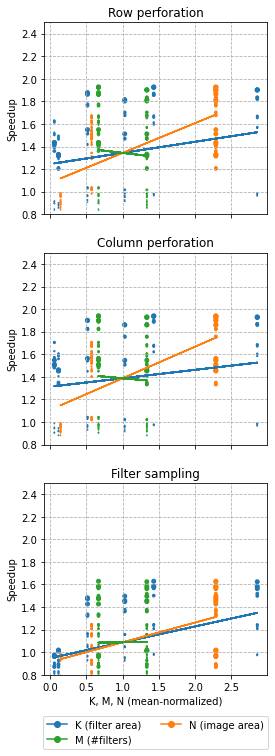

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

df = pd.read_csv("bench_convs.csv").dropna(axis=1)

mode_mapping = {
    0: "Row perforation",
    1: "Column perforation",
    2: "Filter sampling",
}

df["approx_info.mode_name"] = df["approx_info.mode"].map(lambda x: mode_mapping[x])

total_is = "gemm"

if total_is == "im2col":
    df["approx.total"] = df["approx.im2col"]
    df["normal.total"] = df["normal.im2col"]
if total_is == "gemm":
    df["approx.total"] = df["approx.gemm"]
    df["normal.total"] = df["normal.gemm"]
if total_is == "full":
    df["approx.total"] = df["approx.gemm"] + df["approx.im2col"] + df["approx.interpolate"] + df["approx.kn2row"]
    df["normal.total"] = df["normal.gemm"] + df["normal.im2col"]

df["speedup"] = df["normal.total"] / df["approx.total"]
df["chw"] = df["info.c"] * df["info.h"] * df["info.w"]

# df.apply(lambda r:print(r), axis=1)

df["gemm.K"] = df["info.kh"]*df["info.kw"]*df["info.kn"] * \
    (1 - (df.apply(lambda r: 1/r["approx_info.perf_stride"]
     if r["approx_info.mode"] == 2 else 0, axis=1)))

df["gemm.N"] = df["info.w"]*df["info.h"] * \
    (1 - (df.apply(lambda r: 1/r["approx_info.perf_stride"]
     if r["approx_info.mode"] != 2 else 0, axis=1)))

df["gemm.M"] = df["info.kn"]


def get_coeff(x, y):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression()
    lr.fit(x[:, None], y)

    return lr.coef_, lr.intercept_


batch_size = 1
stride = 2

# Select convolutions with normal
sub = df.loc[(df["approx_info.perf_stride"] == stride) & (df["info.n"] == batch_size), :].copy()

sub["w*h"] = sub["info.w"] * sub["info.h"] * sub["info.c"]
sub["w*h"] /= sub["w*h"].mean()


fig, axs = plt.subplots(3, 1, figsize=(4, 12), sharex=True)

axs_d = {mode_mapping[k]: axs[k] for k in mode_mapping}

ck = color = next(plt.gca()._get_lines.prop_cycler)['color']
cn = color = next(plt.gca()._get_lines.prop_cycler)['color']
cm = color = next(plt.gca()._get_lines.prop_cycler)['color']

for name, s in sub.groupby(["approx_info.mode_name"]):
    ax = axs_d[name]

    ax.set_title(f"{name}")

    sizes = np.power(s["w*h"]*4, 1.1)

    s.loc[:, "gemm.K"] /= s["gemm.K"].mean()
    s.loc[:, "gemm.N"] /= s["gemm.N"].mean()
    s.loc[:, "gemm.M"] /= s["gemm.M"].mean()

    coef_K, interc_K = get_coeff(s["gemm.K"].to_numpy(), s["speedup"].to_numpy())
    coef_N, interc_N = get_coeff(s["gemm.N"].to_numpy(), s["speedup"].to_numpy())
    coef_M, interc_M = get_coeff(s["gemm.M"].to_numpy(), s["speedup"].to_numpy())

    ax.plot(s["gemm.K"], s["gemm.K"]*coef_K+interc_K, c=ck)
    ax.scatter(s["gemm.K"], s["speedup"], s=sizes, c=ck)

    ax.plot(s["gemm.N"], s["gemm.N"]*coef_N+interc_N, c=cn)
    ax.scatter(s["gemm.N"], s["speedup"], s=sizes, c=cn)

    ax.plot(s["gemm.M"], s["gemm.M"]*coef_M+interc_M, c=cm)
    ax.scatter(s["gemm.M"], s["speedup"], s=sizes, c=cm)

    ax.plot([], [], 'o-', c=ck, label="K (filter area)")
    ax.plot([], [], 'o-', c=cm, label="M (#filters)")
    ax.plot([], [], 'o-', c=cn, label="N (image area)")

    ax.grid(ls="--")

    ax.set_ylim(0.8, 2.5)
    ax.set_ylabel("Speedup")

axs[-1].set_xlabel("K, M, N (mean-normalized)")
plt.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.savefig(f"conv-benchmark-n{batch_size}-s{stride}-t{total_is}.pdf", bbox_inches='tight')
plt.show()
